In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Use pygeos in geopandas
os.environ['USE_PYGEOS'] = '0'

import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from tqdm.auto import tqdm

from gensit.utils import *
from gensit.utils.notebook_functions import *

%matplotlib inline

# AUTO RELOAD EXTERNAL MODULES
%load_ext autoreload
%autoreload 2

# Sioux Falls Transportation Network
## Import table and geometries

In [3]:
dataset = f'sioux_falls'
table_filename = 'SiouxFalls_od.csv'
geometry_filename = 'SiouxFallsCoordinates.geojson'
cost_filename = 'SiouxFalls_flow.csv'
dest_attraction_filename = 'SiouxFalls_net.tntp'


# Define directory
table_path = f'../data/raw/{dataset}/{table_filename}'
geometries_path = f'../data/raw/{dataset}/{geometry_filename}'
cost_path = f'../data/raw/{dataset}/{cost_filename}'
dest_attraction_path = f'../data/raw/{dataset}/{dest_attraction_filename}'

In [4]:
# Read net flow
netflow = pd.read_csv(dest_attraction_path, skiprows=8, sep='\t').drop(['~', ';'], axis =1)
netflow['edge'] = netflow.index+1
# Compute destination attraction
dest_attraction = netflow.groupby('term_node').sum('capacity').capacity.values

# Read geometries
geometries = gpd.read_file(geometries_path)

In [5]:
# Read table
rawtable = pd.read_csv(table_path)
# Read dimensions
I,J = rawtable.O.max(),rawtable.D.max()

# Populate ground truth table
table = -np.ones((I,J),dtype='int32')

for _,row in rawtable.iterrows():
    table[int(row.O)-1,int(row.D)-1] = int(row.Ton)

# Gather all cells that are negative (these are the fixed cells)
fixed_cells = deepcopy(np.where(table < 0))
# Convert all negative entries to zero
table[table < 0] = 0
# Store all zero-values cells
fixed_cells = np.array([[row,col] for row, col in zip(fixed_cells[0], fixed_cells[1])])

In [145]:
# Read cost
rawflow = pd.read_csv(cost_path,sep='\t')
rawflow = rawflow.rename(columns=dict(zip(rawflow.columns.values,[x.strip() for x in rawflow.columns.values])))
# Populate competitive method prediction
competitive_method = np.zeros((I,J),dtype='float32')
for _,row in rawflow.iterrows():
    rowdict = row.to_dict()
    o,d,v = rowdict['From'],rowdict['To'],rowdict['Volume']
    competitive_method[int(o)-1,int(d)-1] = v

In [143]:
# Merge graph data
graphdata = pd.merge(netflow,rawflow,how='left',left_on=['init_node','term_node'],right_on=['From','To'])

# Create graph object

Code obtained from [Github](https://github.com/marsuconn/sioux-falls-network).

In [146]:
G = nx.from_pandas_edgelist(
    df = graphdata, 
    source = 'init_node', 
    target = 'term_node', 
    edge_attr = ['capacity','length','free_flow_time','b','power','speed','toll','link_type','edge','Volume','Cost'],
    create_using=nx.MultiDiGraph()
)

In [147]:
# Pass geometries to graph
pos_xy = dict([(i,(a,b)) for i, a,b in zip(geometries.id, geometries.x,geometries.y)])

for n, p in pos_xy.items():
    G.nodes[n]['pos_xy'] = p

## Plot network

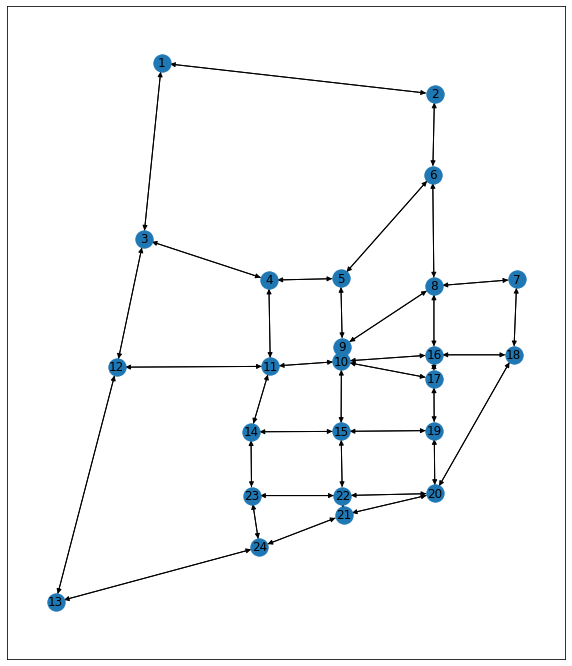

In [148]:
ax,fig = plt.subplots(figsize=(10,12))
nx.draw_networkx(G, pos_xy, with_labels = True)

## Shortest path between nodes in graph

In [149]:
od = [(i+1,j+1) for i in range(I) for j in range(J)]

In [204]:
# Using A* algorithm
path_to_nodes = {}
sp = {}
sp_cost = {}
for i in od:
    path_to_nodes[i] = {'From':i[0],'To':i[1]}
    sp[i] = nx.astar_path(G,i[0],i[1],weight='Cost')
    sp_cost[i] = nx.astar_path_length(G,i[0],i[1],weight='Cost')

In [222]:
df = pd.DataFrame.from_dict(sp_cost, orient='index',columns=['sp_cost'])
# df['sp'] = df.index.map(sp)
df['nodes'] = df.index.to_series().map(path_to_nodes)
# Create cost function from shortest paths
df = pd.concat([df.drop(['nodes'], axis=1), df['nodes'].apply(pd.Series)], axis=1)

# Populate ground truth table
cost = np.ones((I,J),dtype='float32')*0

for _,row in df.iterrows():
    if row.sp_cost > 0:
        cost[int(row.From)-1,int(row.To)-1] = row.sp_cost

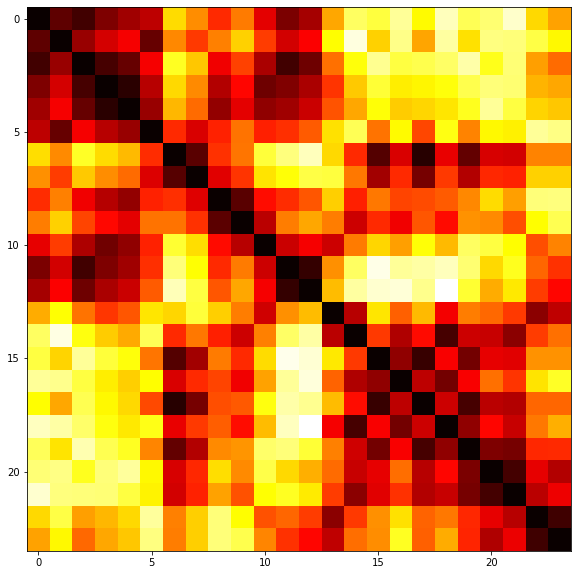

In [223]:
plt.figure(figsize=(10,10))
plt.imshow(cost, cmap='hot', interpolation='nearest')
plt.show()

# Normalise data

In [233]:
rowsums = table.sum(axis=1)
colsums = table.sum(axis=0)

origin_demand_sum_normalised = rowsums/rowsums.sum()
cost_max_normalised = cost/cost.max()
cost_sum_normalised = cost/cost.sum()
dest_attraction_sum_normalised = dest_attraction/dest_attraction.sum()

### True kappa and delta

$$\kappa = \frac{\sum_i O_i+\delta M}{\sum_j W_j}$$
$$\delta = \kappa W_{min}$$

In [225]:
total_w = dest_attraction_sum_normalised.sum()
min_w = np.min(dest_attraction_sum_normalised)
total_o = origin_demand_sum_normalised.sum()
M = J
# Compute kappa, delta
kappa = total_o / (total_w - min_w*M)
delta = kappa * min_w

In [226]:
def kappa_from_delta(d):
    return d / min_w, (total_o+d*M)/total_w
def delta_from_kappa(k):
    return kappa*min_w,(total_w*k-total_o)/M

In [227]:
total_w,total_o

(1.0, 1.0)

In [228]:
kappa,delta

(1.8390477044278934, 0.0349603210178289)

### Export data to file

In [234]:
np.savetxt(f'../data/inputs/{dataset}/ground_truth_table.txt',table)
np.savetxt(f'../data/inputs/{dataset}/competitive_method_table.txt',competitive_method)
np.savetxt(f'../data/inputs/{dataset}/rowsums.txt',rowsums)
np.savetxt(f'../data/inputs/{dataset}/colsums.txt',colsums)
np.savetxt(f'../data/inputs/{dataset}/empty_link_cells.txt',fixed_cells)
np.savetxt(f'../data/inputs/{dataset}/origin_demand_sum_normalised.txt',origin_demand_sum_normalised)
np.savetxt(f'../data/inputs/{dataset}/cost_matrix_max_normalised.txt',cost_max_normalised)
np.savetxt(f'../data/inputs/{dataset}/cost_matrix_sum_normalised.txt',cost_sum_normalised)
np.savetxt(f'../data/inputs/{dataset}/cost_matrix.txt',cost)
np.savetxt(f'../data/inputs/{dataset}/destination_attraction_ts_sum_normalised.txt',dest_attraction_sum_normalised[:,np.newaxis])